In [24]:
# Librerías
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Cargar dataset
df = pd.read_excel("Vulnerabilidades.xlsx", sheet_name="Sheet1")

#Llenamos los campos vacios
df['Nivel de Ingles'] = df['Nivel de Ingles'].fillna('No indicó')
df['Año Experiencia'] = df['Año Experiencia'].fillna(2)


# Separar variables
X = df.drop(columns=["Vulnerabilidad", "Id","OFICIO","OBSERVACIONES GENERALES","ESTADO USA","age_range","age_range2","Score"]) # Variables independientes
y = df["Vulnerabilidad"]  # Variable dependiente

# Convertir variables categóricas a numéricas
categorical_cols = ["SEXO", "Departamento", "Municipio", "Escolaridad","NIVEL ESCOLARIDAD", "SABE INGLES (SI/NO)", "Nivel de Ingles",
                    "Familiares USA"]

#Se define las columnas que tienen datos categoricos y se asigna un valor entero unico a cada categoria
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

# Dividir en entrenamiento y prueba, entrenamiento 70% y prueba 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modelo Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluación Random Forest
print("Random Forest Metrics")

#Matriz de confusión
print(confusion_matrix(y_test, y_pred_rf))

#Reporte de clasificación (Precision, Recall, F1-score)
print(classification_report(y_test, y_pred_rf))

Random Forest Metrics
[[67  0  8]
 [ 0  2  4]
 [ 7  0 98]]
              precision    recall  f1-score   support

        Alta       0.91      0.89      0.90        75
        Baja       1.00      0.33      0.50         6
       Media       0.89      0.93      0.91       105

    accuracy                           0.90       186
   macro avg       0.93      0.72      0.77       186
weighted avg       0.90      0.90      0.89       186



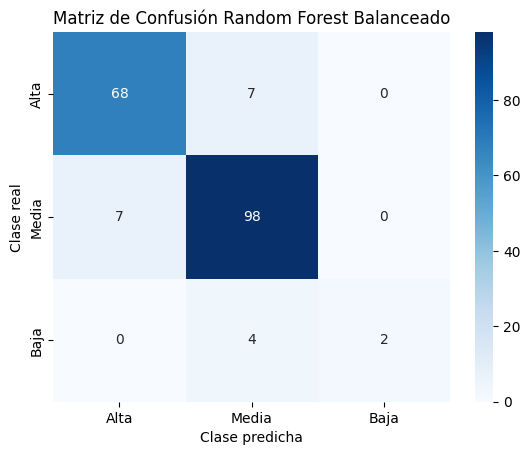

Reporte de Clasificación Random Forest Balanceado
              precision    recall  f1-score   support

        Alta       0.91      0.91      0.91        75
       Media       0.90      0.93      0.92       105
        Baja       1.00      0.33      0.50         6

    accuracy                           0.90       186
   macro avg       0.94      0.72      0.77       186
weighted avg       0.91      0.90      0.90       186



In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Crear modelo Random Forest con balanceo de clases
rf_balanced = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)

# Entrenar modelo
rf_balanced.fit(X_train, y_train)

# Hacer predicciones
y_pred = rf_balanced.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=['Alta', 'Media', 'Baja'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Alta', 'Media', 'Baja'],
            yticklabels=['Alta', 'Media', 'Baja'])
plt.ylabel('Clase real')
plt.xlabel('Clase predicha')
plt.title('Matriz de Confusión Random Forest Balanceado')
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación Random Forest Balanceado")
print(classification_report(y_test, y_pred, labels=['Alta', 'Media', 'Baja']))

In [26]:
# Librerías
import xgboost as xgb

# Convertir y a valores numéricos
le2 = LabelEncoder()
y_encoded = le2.fit_transform(y)  # 'Alta'->0, 'Baja'->1, 'Media'->2

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Modelo XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluación XGBoost
print("XGBoost Metrics")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


XGBoost Metrics
[[71  0  4]
 [ 0  3  3]
 [ 8  0 97]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        75
           1       1.00      0.50      0.67         6
           2       0.93      0.92      0.93       105

    accuracy                           0.92       186
   macro avg       0.94      0.79      0.84       186
weighted avg       0.92      0.92      0.92       186



In [27]:
from imblearn.over_sampling import SMOTE
import numpy as np
# Aplicar SMOTE solo al set de entrenamiento
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verificar nuevo balance de clases
unique, counts = np.unique(y_train_res, return_counts=True)
print("Clases balanceadas tras SMOTE:", dict(zip(le2.inverse_transform(unique), counts)))

# Entrenar modelo XGBoost
xgb = xgb.XGBClassifier(n_estimators=200, max_depth=8, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train_res, y_train_res)

# Predecir sobre el set de prueba
y_pred = xgb.predict(X_test)

# Evaluar desempeño
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le2.classes_))

Clases balanceadas tras SMOTE: {'Alta': 244, 'Baja': 244, 'Media': 244}


C:\Users\ferro\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:24:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Matriz de confusión:
[[71  0  4]
 [ 0  5  1]
 [ 8  1 96]]

Reporte de clasificación:
              precision    recall  f1-score   support

        Alta       0.90      0.95      0.92        75
        Baja       0.83      0.83      0.83         6
       Media       0.95      0.91      0.93       105

    accuracy                           0.92       186
   macro avg       0.89      0.90      0.90       186
weighted avg       0.93      0.92      0.92       186

